## Build and analyze CNS Network with Orthology,  July 7-Aug 3, 2022
- read in CNS network directed graph with edge weights being BLAST similarity scores.
- add CNS node attribute "species", add node attribute "gene", add edge attribute "orthologous gene"



In [1]:
#import libraries
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## 1. Build graph - if you already have a filtered + annotated graph to load skip to step 2.

### I wrote a python/shell script (buildGraph.sh, in this folder) that can be used to build the graph as a cluster job. Useful if you have a lot of nodes and it is taking a long time.

#### import full unmodified CNS node graph

In [3]:
#read in the cns node graph with blast weights from the adjacency list
G = nx.read_weighted_edgelist("adjacencyList.txt")
print("CNS nodes: " + str(G.order())) #nodes
print("connections: " + str(G.size())) #edges

CNS nodes: 136505
connections: 1532608


#### filter graph and add attributes

In [5]:
#add species attribute to all cns nodes (first 2 letters of GeneID)
for n in G.nodes():
    G.nodes[n]['species']=n[0:2]
    

In [6]:
#add gene attributes to all cns nodes, gene length based on species
for n in G.nodes():
    if G.nodes[n]['species'] == 'Zm': #maize
        G.nodes[n]['gene'] = n[0:20]
    elif G.nodes[n]['species'] == 'Os': #rice
        G.nodes[n]['gene'] = n[0:16]
    elif G.nodes[n]['species'] == 'Br': #brachy
        G.nodes[n]['gene'] = n[0:12]
    elif G.nodes[n]['species'] == 'Se': #setaria
        G.nodes[n]['gene'] = n[0:14]
        

In [ ]:
#check that it worked, list the gene attribute of maize (Zm) nodes
[y['gene'] for x,y in G.nodes(data=True) if y['species']=='Zm']

In [ ]:
#if desired, remove all same species edges. If nodes only have same species edges remove node
print("original connection number " + str(G.size()))
G_itr = G.adjacency()
for node, nbrdict in G_itr:
    #if first 3 letters of node label match other node label, remove the edge (First 3 letters relate to species)
    keys = nbrdict.keys()
    remove_edges = []
    for key in keys:
        if node[0:3] == key[0:3]:
            remove_edges.append(key)
    for re in remove_edges:
        G.remove_edge(node,re)
G.remove_nodes_from(list(nx.isolates(G)))
print("updated connection number " + str(G.size()))

#### save graph

In [27]:
#this format saves node and edge attributes
nx.write_gml(mdg, "cns_graph.gml")

#### add attributes between orthologous genes in different species
for multiple ortholog.csv files, change the path (orthoFile), the refSpecies, and the targetSpecies

In [ ]:
directory="orthologs" #set otholog.csv directory. Files are generated from conservatory and in conservatory/genomes. Modified the filesnames to add the ref genome to the beginning.
import os

for filename in os.listdir(directory):
    print("Current file", filename)
    with open(str(directory+"/"+filename), "r") as fp: #open ortholog.csv file
        numLines = sum(1 for line in fp)
        print(numLines)
        quarterDone = int(numLines/4)
        print(quarterDone)
        lineCount = 1
    with open(str(directory+"/"+filename), "r") as fp:
        for line in fp:
            lineArray = line.split(",")
            targetGene = str(lineArray[0])
            refGene = str(lineArray[1])
            #get CNS nodes from graph if they exist
            refCNSs = [n for n,atr in G.nodes(data=True) if atr['gene'] == refGene]
            targetCNSs = [n for n,atr in G.nodes(data=True) if atr['gene'] == targetGene]
            if targetCNSs != [] and refCNSs != []:
                for cns_R in refCNSs:
                    for cns_T in targetCNSs:
                        if G.has_edge(cns_R, cns_T): #check for cns edge
                            print("Connecting", cns_R, cns_T)
                            G.edges[cns_R, cns_T]["orthologous"] = "True"
            
            if lineCount == quarterDone:
                print("25%")
            if lineCount == quarterDone*2:
                print("50%")
            if lineCount == quarterDone*3:
                print("75%")
            if lineCount == numLines:
                print("100%")
            lineCount+=1
    nx.write_gml(G, "cns_graph_orthologs.gml") #re-save graph after processing each file
        


## 2. Load saved graph

In [2]:
#this might take a few mins to load. This is the annotated graph generated with the above code or the buildGraph.sh script.
G = nx.read_gml("cns_graph_orthologs.gml")
print("CNS nodes: " + str(G.order())) #nodes
print("connections: " + str(G.size())) #edges

CNS nodes: 136505
connections: 1532608


In [6]:
#how many ortholog to ortholog CNS blast hits are there?
len(G.edges(data="orthologous"))

17300

#### filter to keep only ortholog edge connections

In [ ]:
remove_edge_one = []
remove_edge_two = []

print("Original CNS nodes: " + str(G.order())) #nodes
print("Original connections: " + str(G.size())) #edges

for u, v, ortho in G.edges(data="orthologous"):
    if ortho is None:
        remove_edge_one.append(u)
        remove_edge_two.append(v)
#print(len(remove_edge_one))
#print(len(remove_edge_two))

x=0
while x < len(remove_edge_one):
    G.remove_edge(remove_edge_one[x],remove_edge_two[x])
    x+=1
    

print("Updated CNS nodes: " + str(G.order())) #nodes
print("Updated connections: " + str(G.size())) #edges

## 3. Analyze graph

In [89]:
#Look up the CNSs and connections associated with favorite gene

myGeneID = "Sevir.3G045500"#"Zm00001eb355240 -ZmRap2"Sevir.2G407600 #setaria gt1 = Sevir.9G508000, setaria vrs1 = Sevir.2G379700, setaria ra3 = Sevir.2G407600, setaria tb1 = "Sevir.9G122200"
#Sevir.3G045500_-335_-91Zm00001eb265610_P001_-300_-98
cnsIDs = []
total_count = 0

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

#look up myGeneID in the combinedCNS.csv, and find all of the CNSs for that gene.
with open("combinedCNS.csv", "r") as fp:
    for line in lines_that_contain(myGeneID, fp):
        lineArray = line.split(",")
        cnsID = str(lineArray[0]) + "_" + str(lineArray[1]) + "_" + str(lineArray[2]) #convert CNS into cnsID
        if (G.has_node(cnsID)):
            print(cnsID + ", Connections: " + str(G.degree[cnsID]))
            print("Connected to: " + str(G.adj[cnsID]) + "\n")
            cnsIDs.append(cnsID)
        total_count += 1

print(str(len(cnsIDs)) + " CNS found for " + str(myGeneID))


Sevir.3G045500_2242_2597, Connections: 1
Connected to: {'Sevir.3G045400_-2847_-2471': {'weight': 151.0}}

Sevir.3G045500_2143_2203, Connections: 1
Connected to: {'Sevir.3G045400_-2943_-2876': {'weight': 884.0}}

Sevir.3G045500_1645_1807, Connections: 2
Connected to: {'Osat.015637998.1_-4602_-4552': {'weight': 1610.0}, 'Sevir.3G045400_-3449_-3231': {'weight': 331.0}}

Sevir.3G045500_968_1019, Connections: 1
Connected to: {'Sevir.3G045400_-4120_-4068': {'weight': 1161.0}}

Sevir.3G045500_8_158, Connections: 1
Connected to: {'Sevir.3G045400_-5078_-4844': {'weight': 358.0}}

Sevir.3G045500_-335_-91, Connections: 3
Connected to: {'Osat.015639330.1_-297_-188': {'weight': 793.0, 'orthologous': 'True'}, 'Zm00001eb265610_P001_-300_-98': {'weight': 400.0, 'orthologous': 'True'}, 'Zm00001eb355240_P002_-318_-93': {'weight': 418.0, 'orthologous': 'True'}}

Sevir.3G045500_-712_-412, Connections: 2
Connected to: {'Zm00001eb355240_P002_-689_-581': {'weight': 869.0, 'orthologous': 'True'}, 'Zm00001eb26

In [ ]:
#Can also look CNSs up this way, via the "gene" node attribute
print("Connections for", myGeneID)
[[x,mdg.adj[x]] for x,y in mdg.nodes(data=True) if y['gene'] == myGeneID]

In [190]:
#subset the graph for cnsID
g = nx.ego_graph(G, "Sevir.7G095500_1110_1184", radius=5)

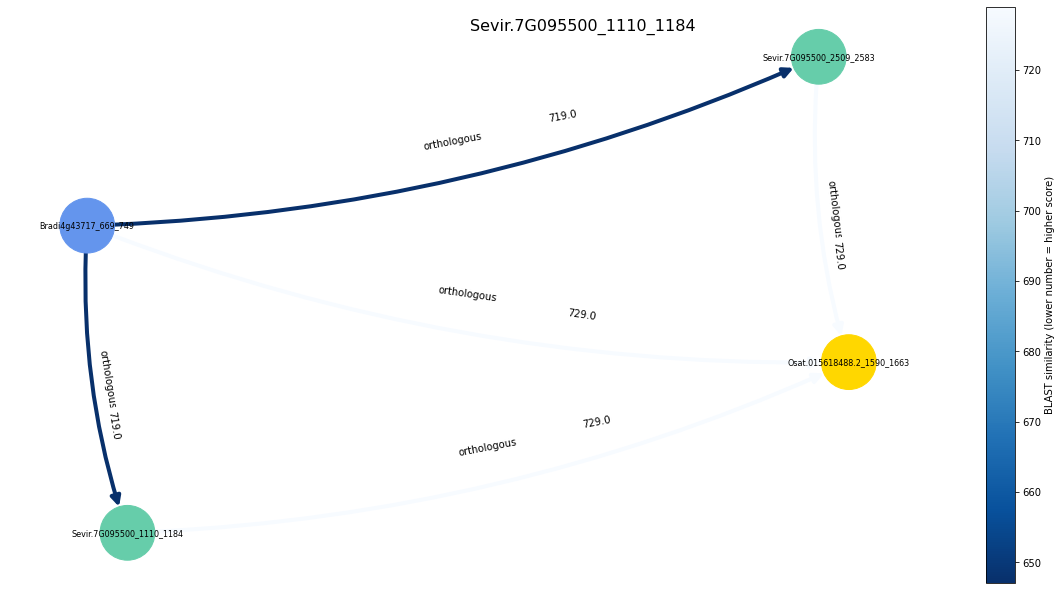

In [191]:
#center node
centerNode = "Sevir.7G095500_1110_1184"

color_map = [] #assign a different color to CNS nodes from different species
for node in g:
    #if node == centerNode:
        #color_map.append('mediumslateblue') #center node is purple
    if node[0:3] == "Bra": #Brachypodium
        color_map.append('cornflowerblue')
    elif node[0:3] == "Sev": #Setaria
        color_map.append('mediumaquamarine')
    elif node[0:3] == "Osa": #Rice
        color_map.append('gold')
    elif node[0:3] == "Zm0": #maize
        color_map.append('salmon')

weightEdges, weight = zip(*nx.get_edge_attributes(g,'weight').items())

fig = plt.figure(centerNode, figsize=(16,8)) #Bradi1g20520 ribonuclease
fig.suptitle(centerNode, fontsize=16)
for edge in g.edges(data=True): edge[2]['label'] = edge[2]['weight']
pos = nx.spring_layout(g, weight='weight', k=12)
edge_labels= nx.get_edge_attributes(g, 'weight')
cmap=plt.cm.Blues_r

nx.draw(g, pos, arrows=True, arrowsize=20, node_color=color_map,node_size=3000,with_labels=True,connectionstyle='arc3, rad = 0.1',edge_color=weight, width =4, edge_cmap = cmap,font_size=8)

edge_labels2=nx.get_edge_attributes(g,'orthologous')
for x in edge_labels2:
    edge_labels2[x]="orthologous"
nx.draw_networkx_edge_labels(g, pos,edge_labels=edge_labels2)
nx.draw_networkx_edge_labels(g, pos,edge_labels=edge_labels,label_pos=0.35)

vmin = min(weight)
vmax = max(weight)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmax, vmax=vmin))
sm._A = []
plt.colorbar(sm, label="BLAST similarity (lower number = higher score)")
plt.show()

In [ ]:
#8/1/2022
#find the most highly conserved CNS networks with the max conserved species

In [7]:
#for all nodes in an ego graph centered around a specific CNS, see if there are at least 4 unique species in the cluster.

#speciesNodes = [n for n in G if n[0:2] !="Zm" ] #uncomment to check non-maize nodes only

import collections as collections
import random

conservedPaths = collections.defaultdict(list)
total_species = 4

def uniqueSpeciesInGraph(subGraph, numSpecies):
    temp_list=[]
    for n in subGraph:
        temp_list.append(n[0:2])
    return len(np.unique(temp_list)) == numSpecies

for n in G:
    g = nx.ego_graph(G, n, radius=5)
    if uniqueSpeciesInGraph(g, total_species):
        conservedPaths[n].append(total_species)

In [8]:
len(conservedPaths)

4691